We are interested in comparing simulations to real data according to summary statistics. One simulated dataset with the same number of cells and genes will be compared to each real dataset, using parameters learned from the dataset. The following characteristics will be compared:

- distribution of gene mean expression
- distribution of gene variance
- gene mean-variance relationship
- distribution of zeros per gene
- gene mean-zeros relationship
- distribution of cell library sizes
- distribution of zeros per cell

In [1]:
import pandas as pd
import numpy as np
from numpy import random

import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

import tree
import simulation as sim
import sim_utils as sut
import count_model as cmod
import tree_utils as tu

Set a random seed for reproducibility:

In [3]:
rseed = 42
np.random.seed(rseed)

Read data and clip the last column to remove awk awkwardness. Learn summary statistics (average expression, variance) for each gene and use them to simulate data with similar characteristics.

Whole zebrafish embryo from 12 timepoints

**Single-cell reconstruction of developmental trajectories during zebrafish embryogenesis**  
Farrell JA, Wang Y, Riesenfeld SJ, Shekhar K, Regev A, Schier AF  
Science 2018

In [4]:
schier_cells = pd.read_csv("/home/npapado/Documents/data/schier_zebrafish/all_cols.txt",
                           sep=" ", header=0, index_col=0)
schier_genes = pd.read_csv("/home/npapado/Documents/data/schier_zebrafish/all_rows.txt",
                           sep=" ", header=0, index_col=0)
del schier_cells[schier_cells.columns.values[-1]]
del schier_genes[schier_genes.columns.values[-1]]

In [17]:
top = tree.Tree.gen_random_topology(10)

branches = np.unique(np.array(top).flatten())
time = {b: 50 for b in branches}
g = 1000 # informative genes
G = schier_genes.shape[1] # total genes
t = tree.Tree(topology=top, G=g, time=time, num_branches=len(branches), branch_points=5, modules=70)

uMs, Ws, Hs = sim.simulate_lineage(t, intra_branch_tol=-1, inter_branch_tol=0)
gene_scale = schier_genes.loc['means']
gene_scale[gene_scale == 0] = 1e-7
t.add_genes(uMs, np.array(gene_scale[0:g]))

/home/npapado/Documents/repos/prosstt/dev/simulation.py:154: UserWarning: No argument 'a' specified in kwargs: using gamma and a=0.04
  "No argument 'a' specified in kwargs: using gamma and a=0.04", UserWarning)
/home/npapado/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [18]:
alpha_mean = np.log(0.01)
alpha_var = np.log(1.5)
beta_mean = np.log(1)
beta_var = np.log(1.5)

alpha = np.exp(random.normal(loc=alpha_mean, scale=alpha_var, size=t.G))
beta = np.exp(random.normal(loc=beta_mean, scale=beta_var, size=t.G)) + 1

In [19]:
X, labs, brns, scalings = sim.sample_density(t, 1000, alpha=alpha, beta=beta)

In [25]:
np.mean(X)

0.17090556436139151

In [26]:
np.mean(schier_genes.loc["means"])

0.19401733246016517

In [20]:
genes_ext = G - g
alpha_ext = np.exp(random.normal(loc=alpha_mean, scale=alpha_var, size=genes_ext))
beta_ext = np.exp(random.normal(loc=beta_mean, scale=beta_var, size=genes_ext)) + 1

ext_gene_params = {"alpha": alpha_ext,
                   "beta": beta_ext,
                   "base_expr": gene_scale[g:]}

In [21]:
X = sim.add_non_diff_genes(X, G-g, ext_gene_params, scalings)

In [22]:
prosstt_means = np.mean(X, axis=0)
prosstt_vars = np.var(X, axis=0)
prosstt_zeros_gene = np.sum(X==0, axis=0)
prosstt_zeros_cell = np.sum(X==0, axis=1)
prosstt_totals = np.sum(X, axis=1)

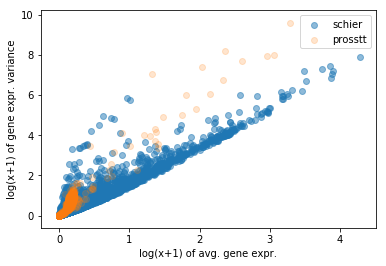

In [24]:
fig, ax = plt.subplots()
ax.set_xlabel("log(x+1) of avg. gene expr.")
ax.set_ylabel("log(x+1) of gene expr. variance")
s1 = ax.scatter(np.log(schier_genes.loc['means']+1),
                np.log(schier_genes.loc['var']+1),
                label="schier", alpha=0.5)
s3 = ax.scatter(np.log(prosstt_means+1),
                np.log(prosstt_vars+1),
                label="prosstt", alpha=0.2)
l = ax.legend()

Whole *Xenopus tropicalis* embrya from multiple developmental timepoints

**The dynamics of gene expression in vertebrate embryogenesis at single-cell resolution**  
James A. Briggs, Caleb Weinreb, Daniel E. Wagner, Sean Megason, Leonid Peshkin, Marc W. Kirschner, Allon M. Klein  
Science, 2018  

In [3]:
klein_cells = pd.read_csv("/home/npapado/Documents/data/klein_xenopus/all_cols.txt",
                          sep=" ", header=0, index_col=0)
klein_genes = pd.read_csv("/home/npapado/Documents/data/klein_xenopus/all_rows.txt",
                          sep=" ", header=0, index_col=0)
# remove non-gene values in the beginning and the awk remnants at the end
del klein_cells[klein_cells.columns.values[-1]]
del klein_genes[klein_genes.columns.values[-1]]
klein_genes = klein_genes[klein_genes.columns.values[8:]]

Axolotl limb regeneration

**Single-cell analysis uncovers convergence of cell identities during axolotl limb regeneration**  
Tobias Gerber, Prayag Murawala, Dunja Knapp, Wouter Masselink, Maritta Schuez, Sarah Hermann, Malgorzata Gac-Santel, Sergej Nowoshilow, Jorge Kageyama, Shahryar Khattak, Joshua D. Currie, J. Gray Camp, Elly M. Tanaka, Barbara Treutlein  
Science, 2018

In [4]:
axo_cells = pd.read_csv("/home/npapado/Documents/data/axolotl/all_cells.txt",
                        sep=" ", header=0, index_col=0)
axo_genes = pd.read_csv("/home/npapado/Documents/data/axolotl/all_genes.txt",
                        sep=" ", header=0, index_col=0)

Cells from hematopoietic progenitors to differentiated blood cells

**Human haematopoietic stem cell lineage commitment is a continuous process**  
Lars Velten _et al._  
Nature Cell Biology, 2018

In [5]:
velten_cells = pd.read_csv("/home/npapado/Documents/data/steinmetz/all_cells.txt",
                              sep=" ", header=0, index_col=0)
velten_genes = pd.read_csv("/home/npapado/Documents/data/steinmetz/all_genes.txt",
                              sep=" ", header=0, index_col=0)

Cells from whole Hydra *vulgaris* sequencing

**Stem cell differentiation trajectories in Hydra resolved at single cell resolution**  
Stephan Siebert *et al.*  
bioRxiv, 2018

In [6]:
hydra_cells = pd.read_csv("/home/npapado/Documents/data/hydra/all_cols.txt",
                           sep=" ", header=0, index_col=0)
hydra_genes = pd.read_csv("/home/npapado/Documents/data/hydra/all_rows.txt",
                           sep=" ", header=0, index_col=0)
del hydra_cells[hydra_cells.columns.values[-1]]
del hydra_genes[hydra_genes.columns.values[-1]]

In [ ]:
prosstt_means = np.mean(X, axis=0)
prosstt_vars = np.var(X, axis=0)
prosstt_zeros_gene = np.sum(X==0, axis=0)
prosstt_zeros_cell = np.sum(X==0, axis=1)
prosstt_totals = np.sum(X, axis=1)

gene average expression versus variance

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("log(x+1) of avg. gene expr.")
ax.set_ylabel("log(x+1) of gene expr. variance")
s1 = ax.scatter(np.log(schier_genes.loc['means']+1),
                np.log(schier_genes.loc['var']+1),
                label="schier", alpha=0.3)
s2 = ax.scatter(np.log(klein_genes.loc['means']+1),
                np.log(klein_genes.loc['var']+1),
                label="klein", alpha=0.3)
s3 = ax.scatter(np.log(prosstt_means+1),
                np.log(prosstt_vars+1),
                label="prosstt", alpha=0.3)
s4 = ax.scatter(np.log(axo_genes.loc['means']+1),
                np.log(axo_genes.loc['var']+1),
                label="axolotl", alpha=0.3)
# s5 = ax.scatter(np.log(velten_genes.loc['means']+1),
#                 np.log(velten_genes.loc['var']+1),
#                 label="velten", alpha=0.05)
s6 = ax.scatter(np.log(hydra_genes.loc['means']+1),
                np.log(hydra_genes.loc['var']+1),
                label="hydra", alpha=0.05)
l = ax.legend()

distribution of gene average expression

/home/npapado/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


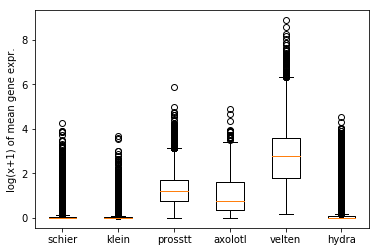

In [88]:
fig, ax = plt.subplots()
ax.set_ylabel("log(x+1) of mean gene expr.")
data = [np.log(schier_genes.loc['means']+1),
        np.log(klein_genes.loc['means']+1),
        np.log(prosstt_means+1),
        np.log(axo_genes.loc['means']+1),
        np.log(velten_genes.loc['means']+1),
        np.log(hydra_genes.loc['means']+1)]
b1 = ax.boxplot(data, labels=["schier", "klein", "prosstt", "axolotl", "velten", "hydra"])

distribution of gene variance

/home/npapado/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


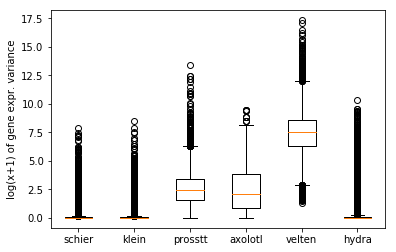

In [89]:
fig, ax = plt.subplots()
ax.set_ylabel("log(x+1) of gene expr. variance")
data = [np.log(schier_genes.loc['var']+1),
        np.log(klein_genes.loc['var']+1),
        np.log(prosstt_vars+1),
        np.log(axo_genes.loc['var']+1),
        np.log(velten_genes.loc['var']+1),
        np.log(hydra_genes.loc['var']+1)]
b1 = ax.boxplot(data, labels=["schier", "klein", "prosstt", "axolotl", "velten", "hydra"])

distribution of zeros per gene

/home/npapado/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


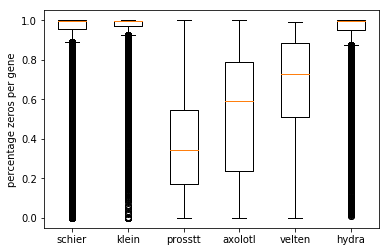

In [90]:
fig, ax = plt.subplots()
ax.set_ylabel("percentage zeros per gene")
data = [(schier_genes.loc['zeros'] / schier_cells.shape[1]),
        (klein_genes.loc['zeros'] / klein_cells.shape[1]),
        (prosstt_zeros_gene / len(prosstt_zeros_cell)),
        (axo_genes.loc['zeros'] / axo_cells.shape[1]),
        (velten_genes.loc['zeros'] / velten_cells.shape[1]),
        (hydra_genes.loc['zeros'] / hydra_cells.shape[1])]
b1 = ax.boxplot(data, labels=["schier", "klein", "prosstt", "axolotl", "velten", "hydra"])

distribution of zeros per cell

/home/npapado/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


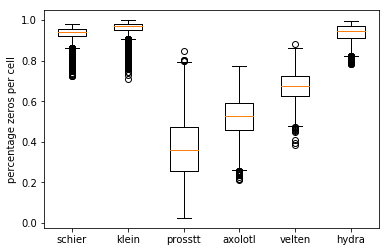

In [91]:
fig, ax = plt.subplots()
ax.set_ylabel("percentage zeros per cell")
data = [(schier_cells.loc['zeros'] / schier_genes.shape[1]),
        (klein_cells.loc['zeros'] / klein_genes.shape[1]),
        (prosstt_zeros_cell / len(prosstt_zeros_gene)),
        (axo_cells.loc['zeros'] / axo_genes.shape[1]),
        (velten_cells.loc['zeros'] / velten_genes.shape[1]),
        (hydra_cells.loc['zeros'] / hydra_genes.shape[1])]
b1 = ax.boxplot(data, labels=["schier", "klein", "prosstt", "axolotl", "velten", "hydra"])

Mean-zeros relationship

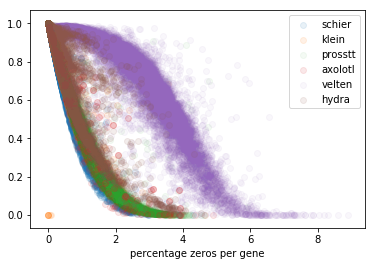

In [93]:
fig, ax = plt.subplots()
ax.set_xlabel("log(x+1) avg. gene expression")
ax.set_xlabel("percentage zeros per gene")
s1 = ax.scatter(np.log(schier_genes.loc['means']+1),
                schier_genes.loc['zeros'] / schier_cells.shape[1],
                label="schier", alpha=0.1)
s2 = ax.scatter(np.log(klein_genes.loc['means']+1),
                klein_genes.loc['zeros'] / klein_cells.shape[1],
                label="klein", alpha=0.1)
s3 = ax.scatter(np.log(prosstt_means+1),
                prosstt_zeros_gene / len(prosstt_zeros_cell),
                label="prosstt", alpha=0.05)
s4 = ax.scatter(np.log(axo_genes.loc['means']+1),
                axo_genes.loc['zeros'] / axo_cells.shape[1],
                label="axolotl", alpha=0.1)
s5 = ax.scatter(np.log(velten_genes.loc['means']+1),
                velten_genes.loc['zeros'] / velten_cells.shape[1],
                label="velten", alpha=0.05)
s6 = ax.scatter(np.log(hydra_genes.loc['means']+1),
                hydra_genes.loc['zeros'] / hydra_cells.shape[1],
                label="hydra", alpha=0.1)
l = ax.legend()

distribution of library sizes

/home/npapado/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


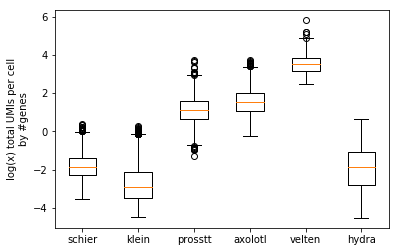

In [94]:
fig, ax = plt.subplots()
ax.set_ylabel("log(x) total UMIs per cell\nby #genes")
data = [np.log(schier_cells.loc['total']/schier_genes.shape[1]),
        np.log(klein_cells.loc['total']/klein_genes.shape[1]),
        np.log(prosstt_totals/20000),
        np.log(axo_cells.loc['total']/axo_genes.shape[1]),
        np.log(velten_cells.loc['total']/velten_genes.shape[1]),
        np.log(hydra_cells.loc['total']/hydra_genes.shape[1])]
b1 = ax.boxplot(data, labels=["schier", "klein", "prosstt", "axolotl", "velten", "hydra"])